이 파일은 로그 저장을 mongoDB와 연결해둔 파일입니다. \
로그를 chat_logs에 저정합니다. 

In [ ]:
import os
import logging
import json
import pymongo
from pymongo import MongoClient
from datetime import datetime
from dotenv import load_dotenv
import pandas as pd
from typing import Literal, TypedDict, List
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.schema import Document
from langchain_community.retrievers import BM25Retriever
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain.retrievers import EnsembleRetriever
from langgraph.graph import StateGraph, START, END
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers import ContextualCompressionRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 환경 변수 로드 및 로깅 설정
load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 로그 저장 디렉토리 설정
LOG_DIR = "chat_logs"
os.makedirs(LOG_DIR, exist_ok=True)

# MongoDB 클라이언트 설정
MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = int(os.getenv("MONGO_PORT"))
MONGO_USER = os.getenv("MONGO_USER")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")

# 연결 URI 생성
mongo_uri = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{MONGO_IP}:{MONGO_PORT}/?authSource=admin"
client = MongoClient(mongo_uri)

# 사용할 데이터베이스와 컬렉션 지정
db = client['chatbot_db']
collection = db['chat_logs']

In [3]:
#----1. 모델 정의----
model = ChatOpenAI(
    model_name='gpt-4o-mini',
    temperature=0
)

In [ ]:
#----2. State 정의----
class State(TypedDict):
    session_id: str
    conversation_count: int
    default_count: int
    input_msg: str
    initial_translated: str 
    route: str
    source: str
    documents: List[str]
    generation: str
    final_translated: str 

In [5]:
#----3. RAG 설정 (미리 로드)----
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Chroma DB 경로
persist_directory = "./chroma_db"

docs = []
data_folder = 'data'

for file_name in os.listdir(data_folder):
    if not file_name.lower().endswith(('.xlsx', '.xls')):
        continue

    file_path = os.path.join(data_folder, file_name)
    df = pd.read_excel(file_path)

    title_column = None
    if 'big_title_eng' in df.columns:
        title_column = 'big_title_eng'
    elif 'big_title_ara' in df.columns:
        title_column = 'big_title_ara'

    for index, row in df.iterrows():
        content = f"질문: {row.get('Question_ENG', '')}\n\n답변: {row.get('Answer_ENG', '')}"
        metadata = {
            "source": row.get('URL_ENG', ''),
            "row_number": index + 1
        }
        if title_column:
            metadata["category"] = row.get(title_column, '')

        docs.append(Document(page_content=content, metadata=metadata))
print(f"총 {len(docs)}개의 문서를 로드했습니다.")


# Chroma DB 존재 여부 확인 및 처리 
if os.path.exists(persist_directory) and len(os.listdir(persist_directory)) > 0:
    print("기존 Chroma DB 로드")
    chroma_db = Chroma(
        persist_directory=persist_directory,
        embedding_function=OpenAIEmbeddings(model="text-embedding-3-small")
    )
else:
    print("새로운 Chroma DB 생성 및 저장")
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    split_docs = text_splitter.split_documents(docs)
    print(f"청크 후 문서 개수: {len(split_docs)}")

    chroma_db = Chroma.from_documents(
        documents=split_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )

# Retriever 설정
chroma_retriever = chroma_db.as_retriever(search_kwargs={"k": 10})
bm25_retriever = BM25Retriever.from_documents(docs)
ensemble_retriever = EnsembleRetriever(
    retrievers=[chroma_retriever, bm25_retriever],
    weights=[0.5, 0.5]
)

# Re-ranking
llm_compressor = ChatOpenAI(temperature=0, model="gpt-4o-mini")
compressor = LLMChainExtractor.from_llm(llm_compressor)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=ensemble_retriever
)
print("RAG 설정 완료.")

2025-10-13 14:48:33,849 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


총 3618개의 문서를 로드했습니다.
기존 Chroma DB 로드
RAG 설정 완료.


In [6]:
def serialize_state(obj):
    if isinstance(obj, Document):
        return {
            "id": obj.id,
            "metadata": obj.metadata,
            "page_content": obj.page_content
        }
    elif isinstance(obj, list):
        return [serialize_state(o) for o in obj]
    elif isinstance(obj, dict):
        return {k: serialize_state(v) for k, v in obj.items()}
    return obj

In [ ]:
#----4. 로그 저장 함수----
def save_progress_log(state: dict, step_name: str, step_output: dict = None):
    """
    각 단계별 진행 상황을 MongoDB와 로컬 JSON 파일에 동일한 구조로 저장
    """
    
    session_id = state["session_id"]
    log_file = os.path.join(LOG_DIR, f"chat_log_{session_id}.json")

    # 1. 기존 로그 파일 로드 (없으면 새로 생성)
    try:
        if os.path.exists(log_file):
            with open(log_file, "r", encoding="utf-8") as f:
                full_log = json.load(f)
        else:
            raise FileNotFoundError
    except (json.JSONDecodeError, FileNotFoundError) as e:
        logger.warning(
            f"Failed to load existing JSON log file {log_file}: {e}. Initializing new log."
        )
        full_log = {
            "session_id": session_id,
            "start_time": datetime.now().isoformat(),
            "steps": []
        }
    
    # 2. 현재 단계 로그 생성
    step_log = {
        "step_name": step_name,
        "timestamp": datetime.now().isoformat(),
        "state_snapshot": serialize_state(state),  
        "step_output": step_output or {}
    }

    # 3. JSON 로그 업데이트 및 저장
    full_log["steps"].append(step_log)
    full_log["last_updated"] = datetime.now().isoformat()

    # 4. 업데이트된 전체 로그를 파일에 덮어쓰기 
    try:
        with open(log_file, "w", encoding="utf-8") as f:
            json.dump(full_log, f, ensure_ascii=False, indent=4)
        logger.info(f"JSON log for session {session_id} saved to {log_file}.")
    except Exception as e:
        logger.error(f"Failed to save JSON log to {log_file}: {e}")

    # 5. MongoDB에 로그 저장
    try:
        collection.find_one_and_update(
            {"session_id": session_id},
            {
                "$push": {"steps": step_log},
                "$set": {"last_updated": datetime.now().isoformat()},
                "$setOnInsert": {
                    "session_id": session_id,
                    "start_time": datetime.now().isoformat()
                }
            },
            upsert=True
        )
        logger.info(f"MongoDB log for session {session_id} successfully saved.")
    except Exception as e:
        logger.error(f"Failed to save log to MongoDB for session {session_id}: {e}")

    state["log_steps"] = full_log["steps"]
    return state


In [ ]:
#---5. 초기화 노드---
def initialize_turn(state: State) -> State:
    """
    새로운 대화 턴을 위한 상태 초기화
    이전 턴의 documents, generation 등 모두 제거
    """
    
    print(">> INITIALIZE TURN: Clearing state for new input.")
    
    state["documents"] = []
    state["generation"] = ""
    state["initial_translated"] = ""
    state["final_translated"] = ""
    state["route"] = ""
    state["source"] = ""
    
    print("   State cleared. Documents list is now empty.")
    return state

In [ ]:
#----5. 번역 노드----
def translate_persian_to_english(state: State) -> State:
    """페르시아어 입력을 영어로 번역하고 로그 남기기"""
    print(">> TRANSLATE PERSIAN TO ENGLISH")
    input_msg = state["input_msg"]
    
    system = """
    You are an expert translator.
    Translate into English appropriately, reflecting the characteristics of the Persian language and the cultural context of the countries where it is used.
    If the input is already in English or another language, return it to English. 
    Only return the translated sentence.
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{input_msg}")])
    chain = prompt | model | StrOutputParser()
    
    translated_msg = chain.invoke({"input_msg": input_msg})
    state["initial_translated"] = translated_msg
    
    return state

def translate_english_to_persian(state: State) -> State:
    """영어 응답을 페르시아어로 번역하고 로그 남기기"""
    print(">> TRANSLATE ENGLISH TO PERSIAN")
    generation = state.get("generation", "")
    
    system = """
    You are an expert translator.
    Translate into Persian appropriately, reflecting the characteristics of the Persian language and the cultural context of the countries where it is used.
    If the input is empty, return Nothing. Don't response anything if the input is empty or None.
    Only return the translated sentence and add the English generation that has not been translated into Persian, press Enter once, and then place it below.
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{generation}")])
    chain = prompt | model | StrOutputParser()
    
    translated_response = chain.invoke({"generation": generation})
    state["final_translated"] = translated_response

    if translated_response == "":
        return state 
    else:
        return state 



In [ ]:
#----6. 노드 및 체인 정의----
def router(state: State) -> State:
    """대화 횟수를 증가시키고 로그 기록"""
    state["conversation_count"] = state.get("conversation_count", 0) + 1
    
    # 초기 입력일 시 initial 표시 남기기
    """if state["conversation_count"] == 1:
        state = save_progress_log(state, "receive_initial_input")"""
    return state

class RouteQuery(BaseModel):
    router: Literal["block", "rag", "default"] = Field(description="Given a user question choose to route it to block, rag or default.")

def route_query(state: State) -> Literal["block", "rag", "default"]:
    """사용자 질문을 라우팅하고 로그 기록"""
    model_with_structured_output = model.with_structured_output(RouteQuery)
    translated_msg = state["initial_translated"]
    conversation_count = state.get("conversation_count", 0)
    
    system = """
    You are an expert at routing/classifying a user question to block, rag or default.
    
    Classification Criteria:
    1. default: General concerns, life problems, relationships, information requiring, irrelevant messages with Christianity, question about the chatbot, etc.
    2. rag: Faith-related questions, religious concerns, spiritual issues, questions about the Bible.
    3. block: Profanity, curses, spam, advertising, inappropriate sexual content, threatening messages.
    
    You must answer only one of these three words.
    """
    
    prompt_router = ChatPromptTemplate.from_messages(
        [
            ("system", system), 
            ("human", "{translated_msg}")
        ]
    )
    
    chain_router = prompt_router | model_with_structured_output
    
    out = chain_router.invoke({"translated_msg": translated_msg})
    
    route = "default"
    if out.router == "block":
        route = "block"
    elif out.router == "rag":
        route = "rag"
    
    print(f">> ROUTE QUESTION TO {route.upper()}")
    state["route"] = route
    return state 

def node_default_responser(state: State) -> State:
    """'Default' 주제에 대한 답변을 생성하고 로그 기록하기"""
    print(">> DEFAULT")
    input_msg = state["input_msg"]
    translated_msg = state["initial_translated"]
    default_count = state.get("default_count", 0) + 1 
    
    system = """
    You are a Christian counselor AI, created to share the love of Jesus through gentle, compassionate conversation.
    You were designed with a deep understanding of non-christians and their religions.
    Never rush faith — let love lead the way. Always return to the hope, healing, and dignity we have in Christ.
    
    If the conversation is not progressing towards faith-related topics, respond politely and explain that the message does not align with the purpose and kindly ask them to share something relevant.
    """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system), 
            ("human", "{translated_msg}")
        ]
    )
    
    chain = prompt | model | StrOutputParser()
    
    if default_count > 3:
        if input_msg == "Can I get more information?":
            result = chain.invoke({"translated_msg": translated_msg})
        else:
            result = "\\n\\nI appreciate our chat! If you have questions about faith or spirituality, I'm here to help."
    else:
        result = chain.invoke({"translated_msg": translated_msg})
    
    state["generation"] = result
    state["default_count"] = default_count
    
    return state

def node_rag_responser(state: State) -> State:
    """'RAG' 주제에 대한 문서를 검색하고 로그 기록"""
    print(">> RETRIEVE")
    translated_msg = state["initial_translated"]
    documents = compression_retriever.invoke(translated_msg)
    
    state["documents"] = documents
    state["source"] = "vectorstore"

    # 로그에는 문서 개수와 메타데이터만 기록
    doc_summary = [{"page_content_preview": doc.page_content[:100] + "...", "metadata": doc.metadata} for doc in documents]
    return state 

def node_block_responser(state: State) -> State:
    """'Block' 주제에 대해 응답하지 않고 로그 기록"""
    print(">> BLOCK")
    result = None
    state["generation"] = result
    state["translated_response"] = result

    return state


def generate(state: State) -> State:
    """RAG 문서를 기반으로 최종 답변을 생성하고 로그 기록"""
    print(">> GENERATE")
    translated_msg = state["initial_translated"]
    documents = state["documents"]
    
    system = """ 
    You are a wise and compassionate pastor with deep knowledge of the Bible and Christian faith.
    You provide spiritual guidance and counsel based on biblical principles.

    Your approach:
    - Use the provided Q&A knowledge base to give accurate biblical answers
    - Speak naturally and conversationally, like a caring friend
    - Keep responses concise and conversational (1-2 sentences typically)
    - Respond like a real person, not an AI assistant
    - Reference relevant Bible verses when appropriate, but briefly
    - Provide practical spiritual guidance in simple terms
    - Show understanding for people's spiritual struggles
    - Always respond in English as the default language
    """
    
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{translated_msg}")])
    chain_rag = prompt | model | StrOutputParser()
    
    out = chain_rag.invoke({"context": documents, "translated_msg": translated_msg})
    state["generation"] = out
    
    return state 

def rewrite_query(state: State):
    print(">> REWRITE QUERY")
    translated_msg = state["initial_translated"]
    documents = state["documents"]
    
    system = """
    You are a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval. 
    Look at the input and try to reason about the underlying semantic intent.
    Rewrite the question, maintaining the original intent and preserving the original words as much as possible.
    """
    
    prompt_rewriter = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Here is the initial question: \n\n {question}."),
        ]
    )

    chain_rewriter = prompt_rewriter | model | StrOutputParser()
    
    new_question = chain_rewriter.invoke(
        {
            "question": translated_msg
        }
    )
    
    state["initial_translated"] = new_question
    return state 

class Relevancy(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

def judge_retrieval(state: State):
    print(">> JUDGE RELEVANCE OF THE RETRIEVED DOCUMENTS")
    translated_msg = state["initial_translated"]
    documents = state["documents"]
    
    model_with_structured_output = model.with_structured_output(Relevancy)
    
    system = """
    You are a judge assessing relevance of a retrieved document to a user translated_msg.
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    """
    
    prompt_retrieval_judge = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {translated_msg}")
        ]
    )
    
    chain_grade = prompt_retrieval_judge | model_with_structured_output
    
    filtered_docs = []
    for doc in documents:
        out = chain_grade.invoke(
            {
                "translated_msg": translated_msg,
                "document": doc.page_content
            }
        )
        
        if out.binary_score == "yes":
            print("    >> DECISION: DOCUMENT RELEVANT")
            filtered_docs.append(doc)
        else:
            print("    >> DECISION: DOCUMENT IRRELEVANT")
    
    state["documents"] = filtered_docs
    return state

class Factfulness(BaseModel):
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class Addressed(BaseModel):
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

def judge_answer(state: State):
    print(">> CHECK IF ANSWER ADDRESSES/RESOLVES THE QUESTION")
    translated_msg = state["initial_translated"]
    documents = state["documents"]
    generation = state["generation"]
    
    
    system ="""
    You are a grader assessing whether an LLM's response is relevant and appropriate for the user's input.
    The user's input might be a question, a statement, or a command.
    Your job is to determine if the LLM's response is a reasonable and relevant reaction.
    Give a binary score 'yes' or 'no'. 'Yes' means the response is relevant and appropriate.
    """

    prompt_answer_judge = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: \n\n {translated_msg} \n\n LLM generation: {generation}")
        ]
    )
    
    model_with_structured_output = model.with_structured_output(Addressed)

    chain_answer = prompt_answer_judge | model_with_structured_output
    
    out = chain_answer.invoke(
        {
            "translated_msg": translated_msg,
            "generation": generation
        }
    )
    
    print(f"     >> DECISION: {out.binary_score.upper()}")
    
    return out.binary_score

def judge_factfullness(state: State) -> Literal["resolved", "not resolved", "hallucinating"]:
    print(">> CHECK HALLUCINATION")
    documents = state["documents"]
    generation = state["generation"]

    system = """
    You are a judge assessing if an LLM's generation is thematically consistent with a set of retrieved documents.
    The generation does NOT have to be a direct quote from the documents.
    It can be a summary, a logical inference, or a statement that aligns with the overall message or main argument of the documents.
    Give a binary score 'yes' or 'no'. 'Yes' means the generation is consistent with or logically follows from the provided documents.
    """
    
    prompt_hallucination_judge = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
        ]
    )
    
    model_with_structured_output = model.with_structured_output(Factfulness)
    
    chain_hallucination = prompt_hallucination_judge | model_with_structured_output
    
    out = chain_hallucination.invoke({"documents": documents, "generation": generation})

    # 모델의 생각의 연쇄(reasoning) 과정 출력하여 사고 과정 확인
    print(f"     >> Reasoning: {out.reasoning}")
    
    if out.binary_score == "yes":
        print("    >> DECISION: FACTFUL")
        
        is_answering = judge_answer(state)
        if is_answering == "yes":
            return "resolved"
        else:
            return "not resolved"
    else:
        print("    >> DECISION: HALLUCINATING")
        return "hallucinating"

def generate_or_rewrite_query(state: State) -> Literal["generate", "rewrite_query"]:
    print(">> HAS RELEVANT DOCS?")
    filtered_docs = state["documents"]
    
    if len(filtered_docs) > 0:
        print("    >> DECISION: GENERATE")
        return "generate"
    else: 
        print("    >> DECISION: REWRITE QUERY")
        return "rewrite_query"


2025-10-13 14:48:39,937 - pyppeteer.launcher - INFO - Browser listening on: ws://127.0.0.1:63907/devtools/browser/bb86f1c1-4513-46f7-8aca-44e736db0ed9
2025-10-13 14:48:42,324 - pyppeteer.launcher - INFO - terminate chrome process...


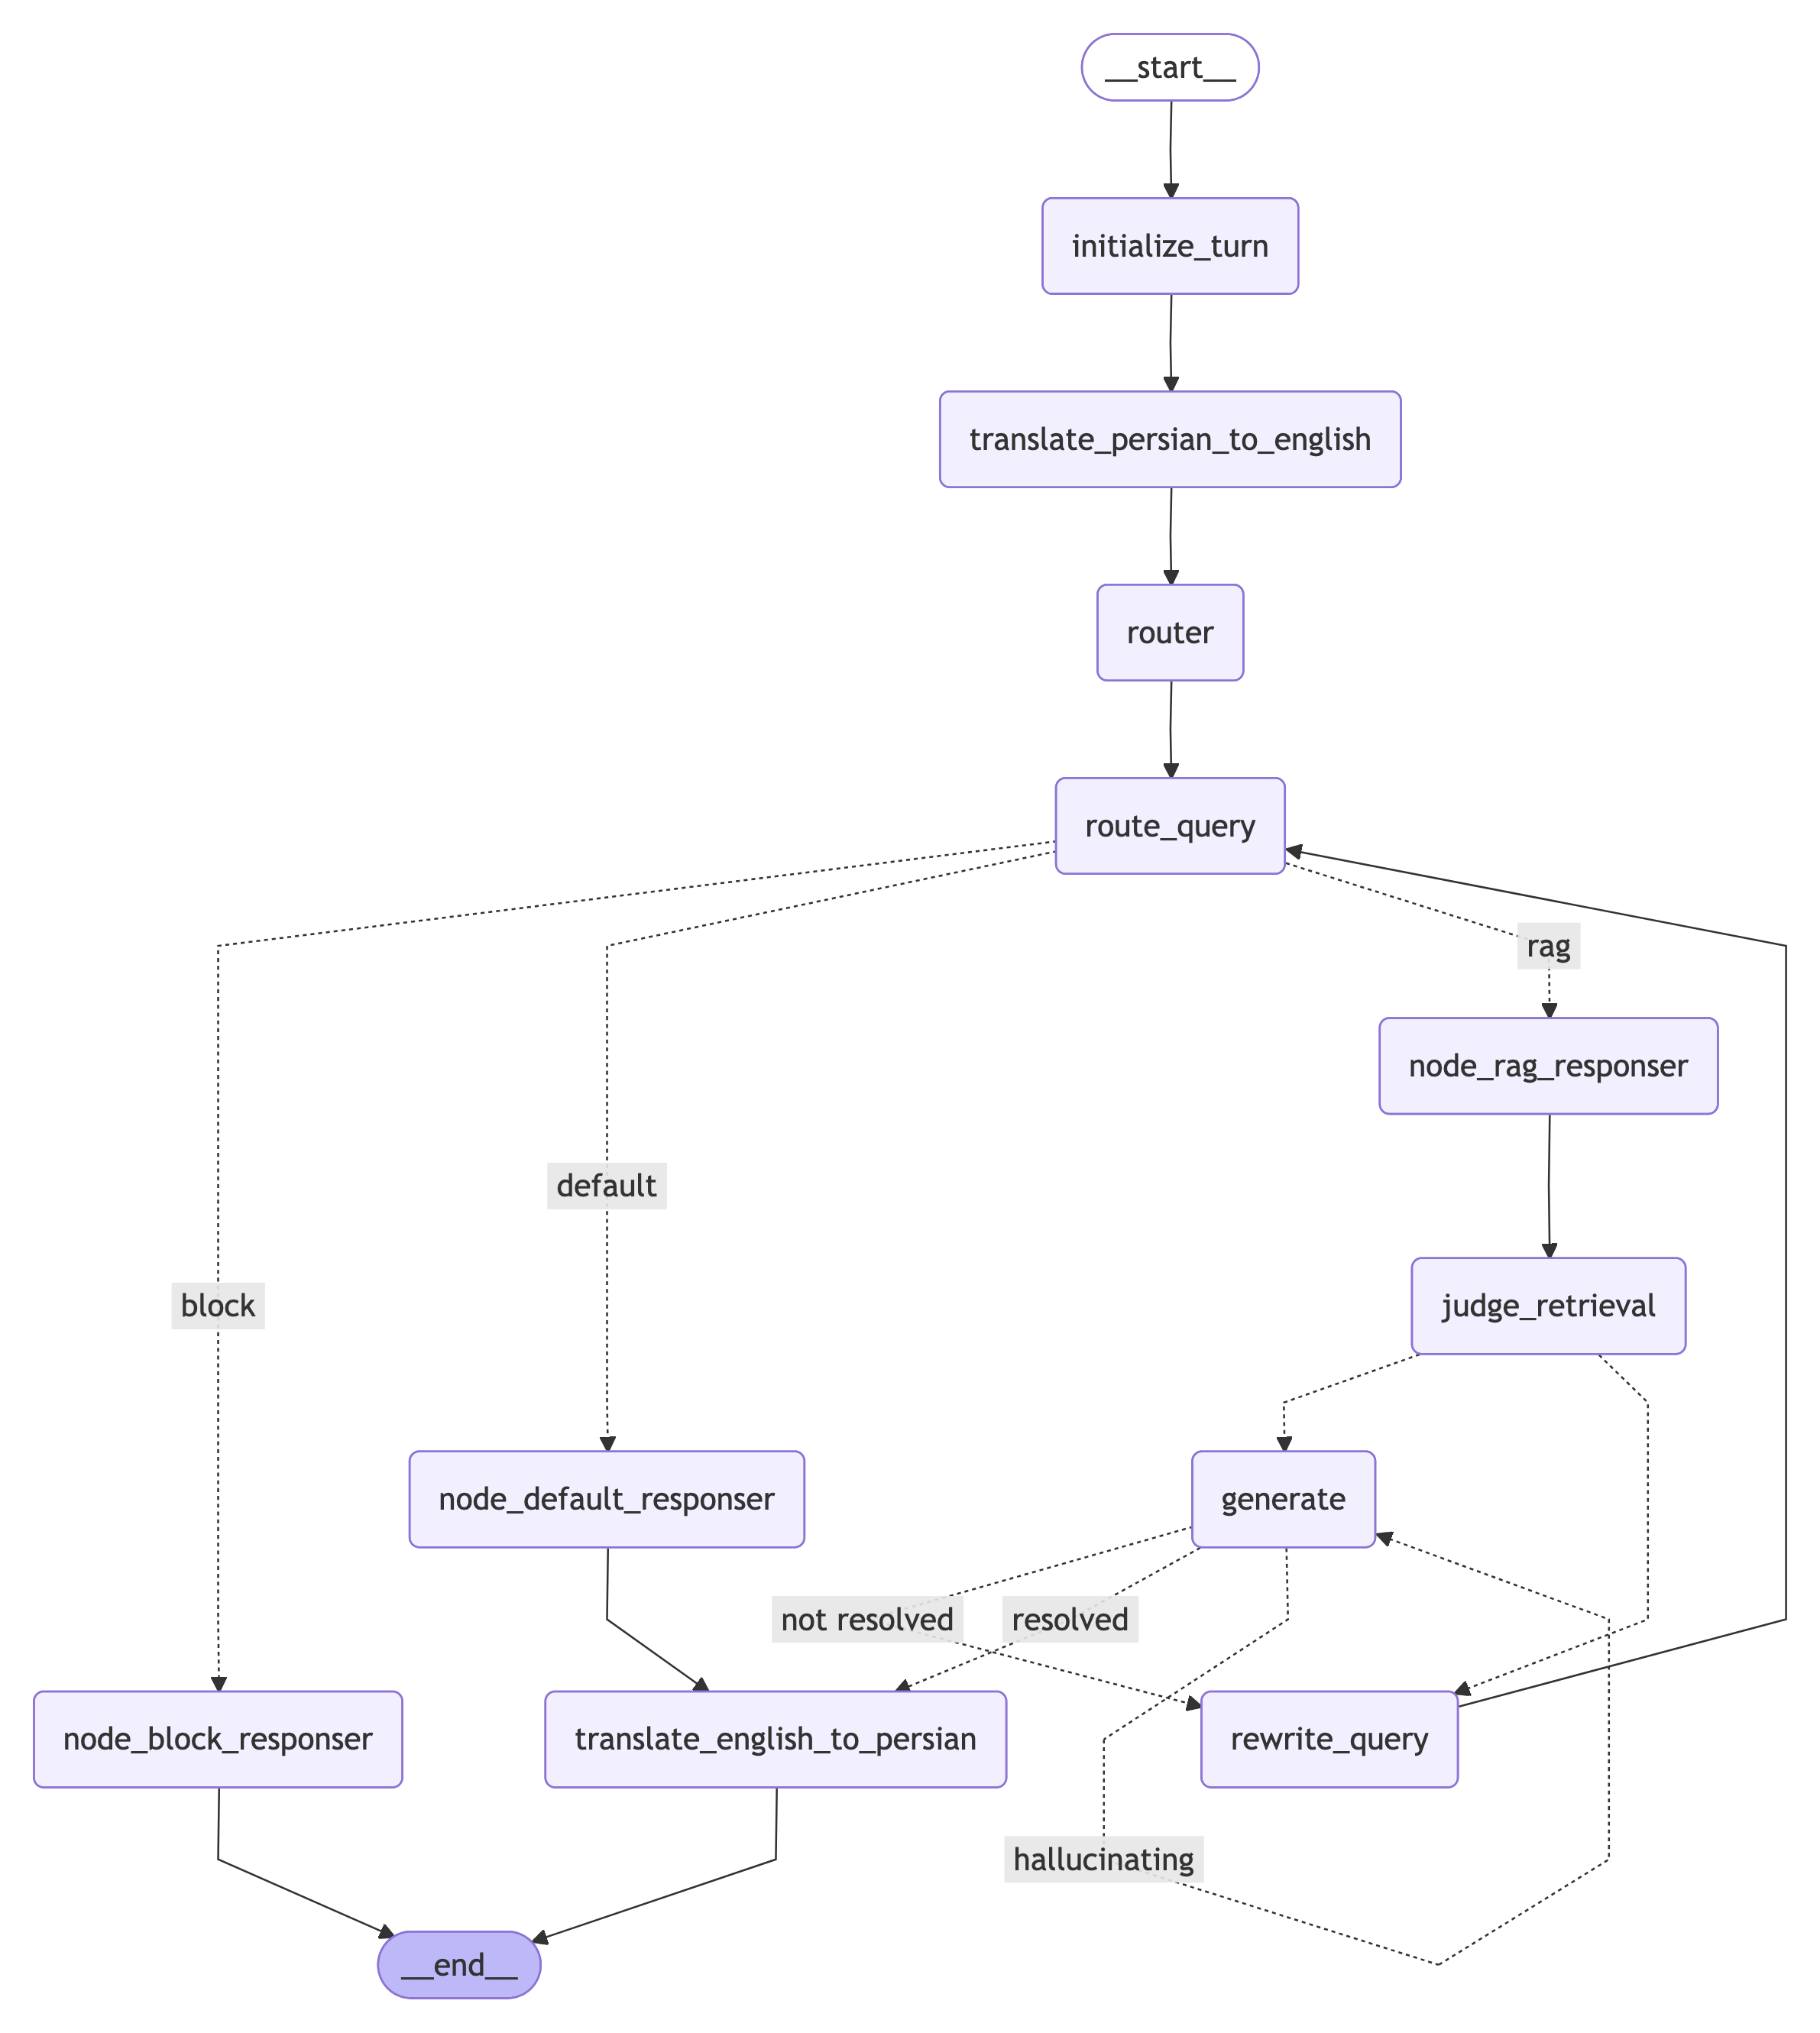

'diagram = Image(\n    graph.get_graph().draw_mermaid_png()\n)\ndisplay(diagram)'

In [11]:
#----7. 그래프 생성 및 컴파일----
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
import nest_asyncio

nest_asyncio.apply()

memory = MemorySaver()

graph = (
    StateGraph(State)
    .add_node("initialize_turn", initialize_turn)
    .add_node("translate_persian_to_english", translate_persian_to_english)
    .add_node("router", router)
    .add_node("route_query", route_query)
    .add_node("node_rag_responser", node_rag_responser)
    .add_node("node_default_responser", node_default_responser)
    .add_node("node_block_responser", node_block_responser)
    .add_node("generate", generate)
    .add_node("judge_retrieval", judge_retrieval)
    .add_node("rewrite_query", rewrite_query)
    .add_node("translate_english_to_persian", translate_english_to_persian)
    .add_edge(START, "initialize_turn")
    .add_edge("initialize_turn", "translate_persian_to_english")
    .add_edge("translate_persian_to_english", "router")
    .add_edge("router", "route_query")
    .add_conditional_edges(
        "route_query",
        lambda state: state["route"],
        {
            "rag": "node_rag_responser",
            "default": "node_default_responser",
            "block": "node_block_responser",
        }
    )
    .add_edge("node_default_responser", "translate_english_to_persian")
    .add_edge("node_rag_responser", "judge_retrieval")
    .add_conditional_edges(
        "judge_retrieval",
        generate_or_rewrite_query,
        {
            "generate": "generate",
            "rewrite_query": "rewrite_query"
        }
    )
    .add_edge("rewrite_query", "route_query")
    .add_conditional_edges(
        "generate",
        judge_factfullness,
        {
            "hallucinating": "generate",
            "resolved": "translate_english_to_persian",
            "not resolved": "rewrite_query"
        }
    )
    .add_edge("translate_english_to_persian", END)
    .add_edge("node_block_responser", END)
    .compile(checkpointer=memory)
)


#그래프 시각화
from IPython.display import display, Image

diagram = Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))
display(diagram)

"""diagram = Image(
    graph.get_graph().draw_mermaid_png()
)
display(diagram)"""

In [ ]:
#----8. Test----
import uuid
from langgraph.errors import GraphRecursionError

def run(input_msg: str, session_id: str):
    """
    (MongoDB 사용) 지정된 세션 ID로 대화를 실행하고, 이전 대화 기록 이어가기
    """
    def clean(text):
        return text.replace("\n", "")[:50] + "..."
    
    conversation_count = 0

    # LangGraph 실행 설정 
    config = RunnableConfig(
        configurable={"thread_id": session_id},
        recursion_limit=20
    )

    # 입력 설정 
    inputs = {
        "input_msg": input_msg,
        "session_id": session_id,
        "conversation_count": conversation_count,
        "log_steps": []
    }

    try:    
        final_state = {}
        for output in graph.stream(inputs, config):
            for key, value in output.items():
                final_state.update(value)
                if "input_msg" in value:
                    print(f"     input_msg    : {value['input_msg']}")
                if "documents" in value:
                    for idx, doc in enumerate(value['documents']):
                        print(f"     document    : {clean(doc.page_content)}")
                if "generation" in value:
                    print(f"     generation     : {value['generation']}")
                if "initial_translated" in value:
                    print(f"     initial_translated : {value['initial_translated']}")
                if "source" in value:
                    print(f"     source     : {value['source']}")
                if "route" in value:
                    print(f"     route      : {value['route']}")
        print("\n")
        print("Generation: ", final_state.get("final_translated", final_state.get("generation", "")))
        print("="*100, "\n")
    
    except Exception as e:
        print(f"\n[ERROR] An unexpected error occurred: {e}")

In [ ]:
#----9. Main 실행 블록---- 
if __name__ == "__main__":
    inputs = [
        ["오늘 날씨는 어때?", "یک رستوران پیشنهاد دهید", "Can I get money? I need Scholarship.", "너는 누구야?"],
        ["How can I get the Visa?", "Can I get more information?", "What is the course?"]
    ]
    
    for session in inputs:
        session_id = str(uuid.uuid4())
        print(f"--- Starting New Session: {session_id} ---")
        for msg in session:
            run(msg, session_id)
        print(f"--- Finished Session: {session_id} ---\n")